In [1]:
# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *

import json


from IPython.display import Image



from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import sklearn.cross_validation as cross_validation

/usr/local/lib/python2.7/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


In [2]:
df_left = pd.read_csv('data/merged/look_left.csv')
df_right = pd.read_csv('data/merged/look_right.csv')

df_straight = pd.read_csv('data/merged/look_straight.csv')
### hack
# Assume class 0 is always when face is forward for any data set

# look-right events are class 3 and 4
df_right['class'] = df_right['class'].apply(lambda x: x + 2 if x > 0 else 0)
df = pd.concat([df_left, df_right, df_straight])
n = len(df)



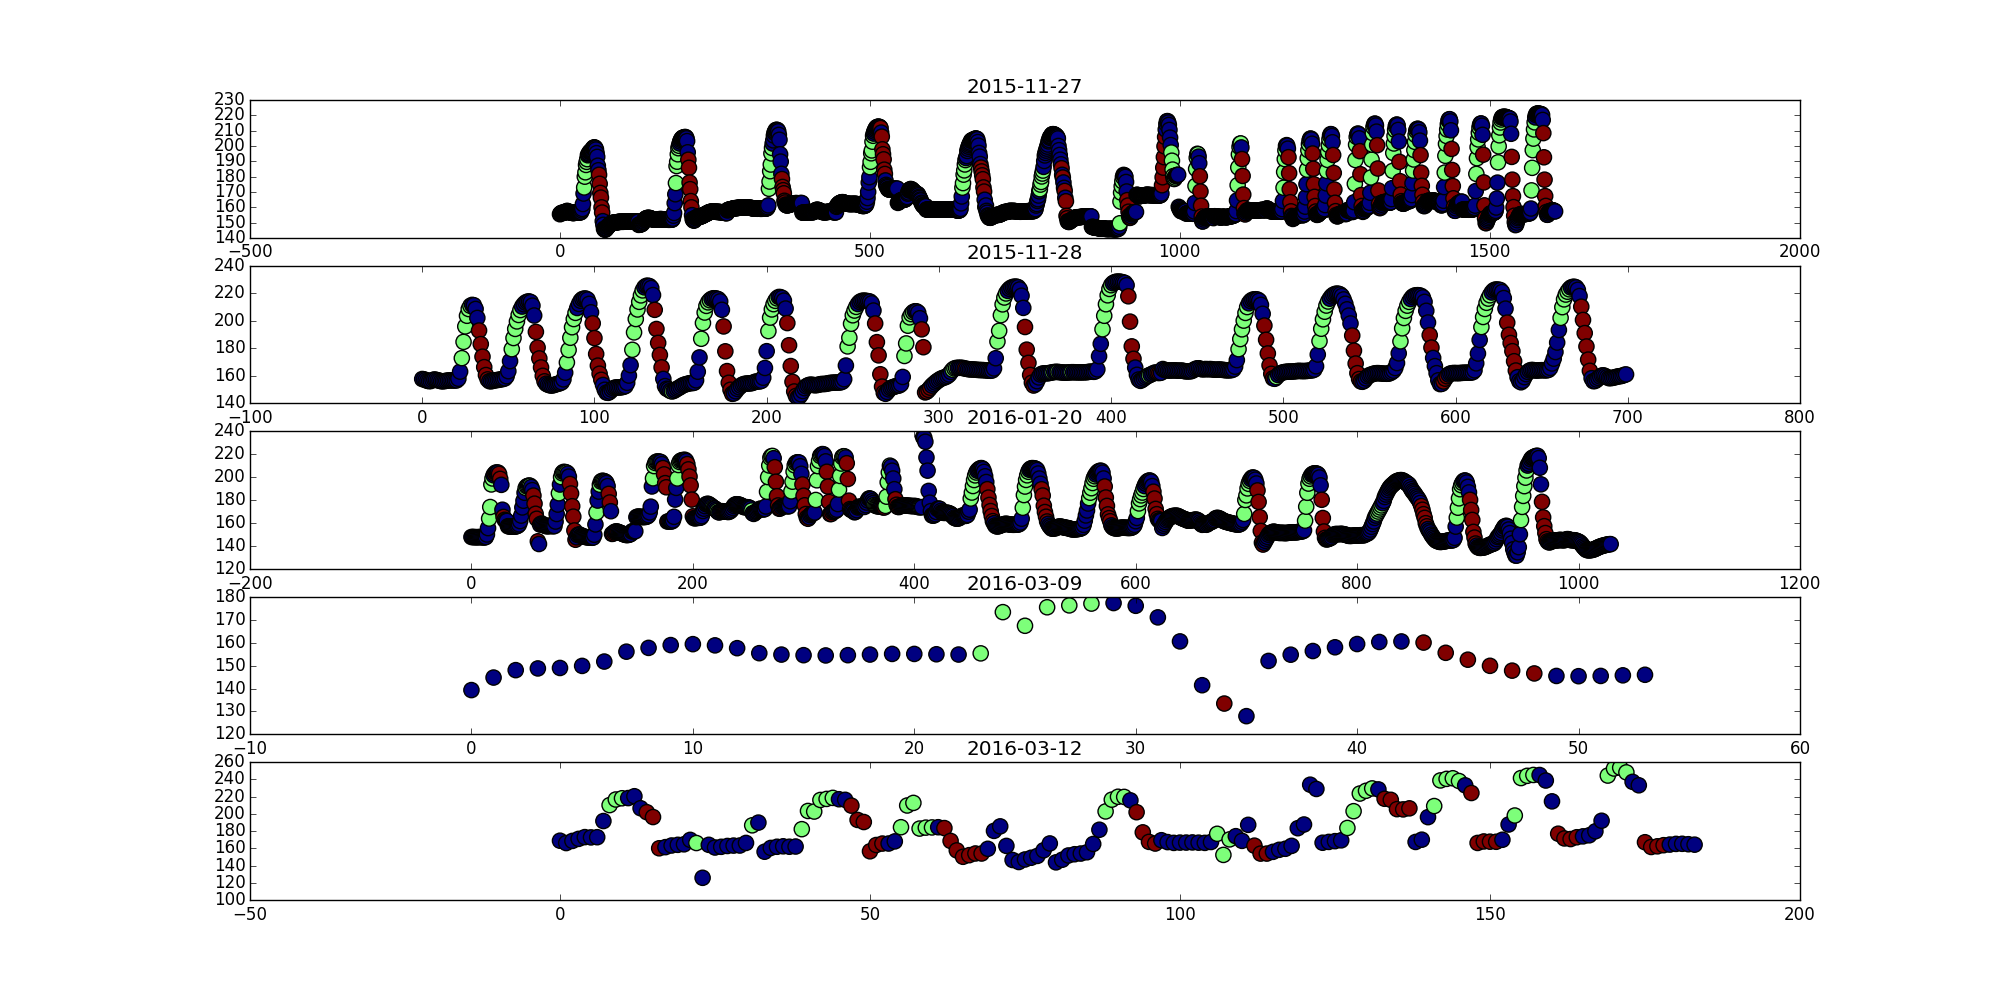

In [3]:
Image(filename='data/merged/look_left-plots.png')


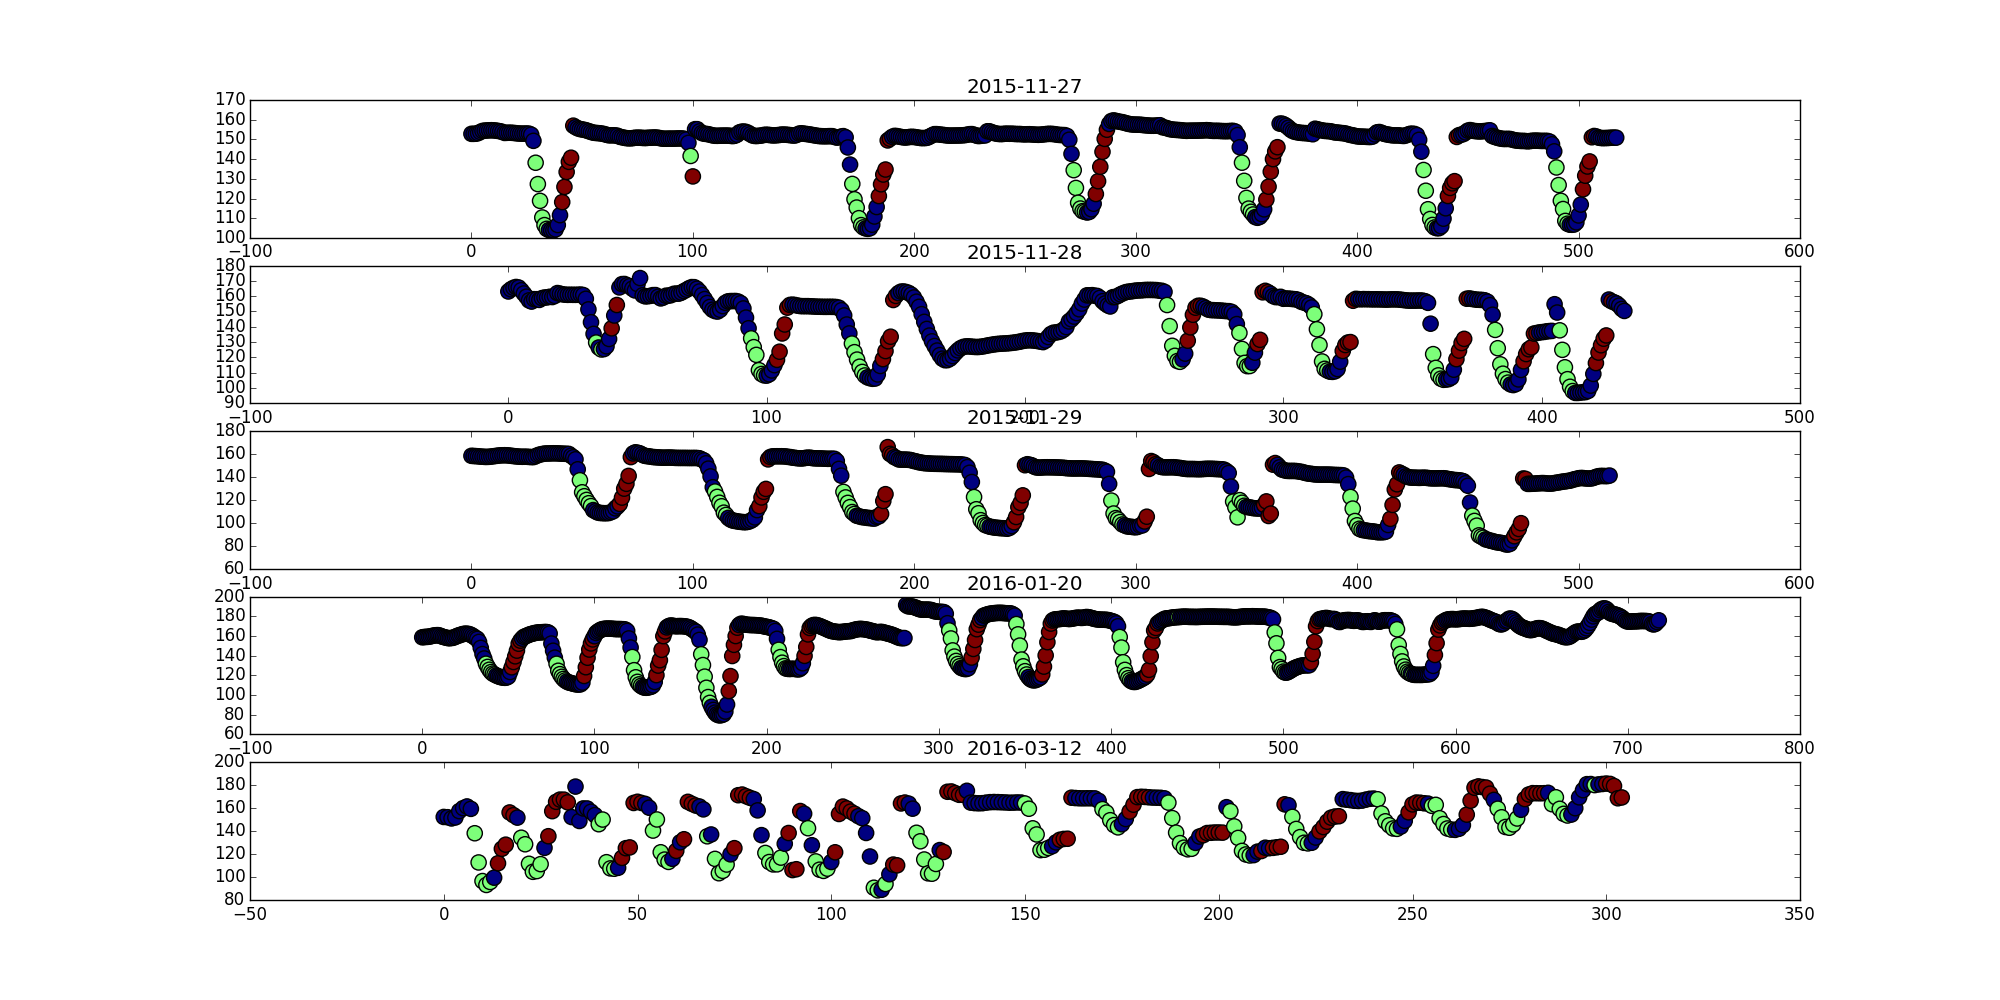

In [4]:
Image(filename='data/merged/look_right-plots.png')

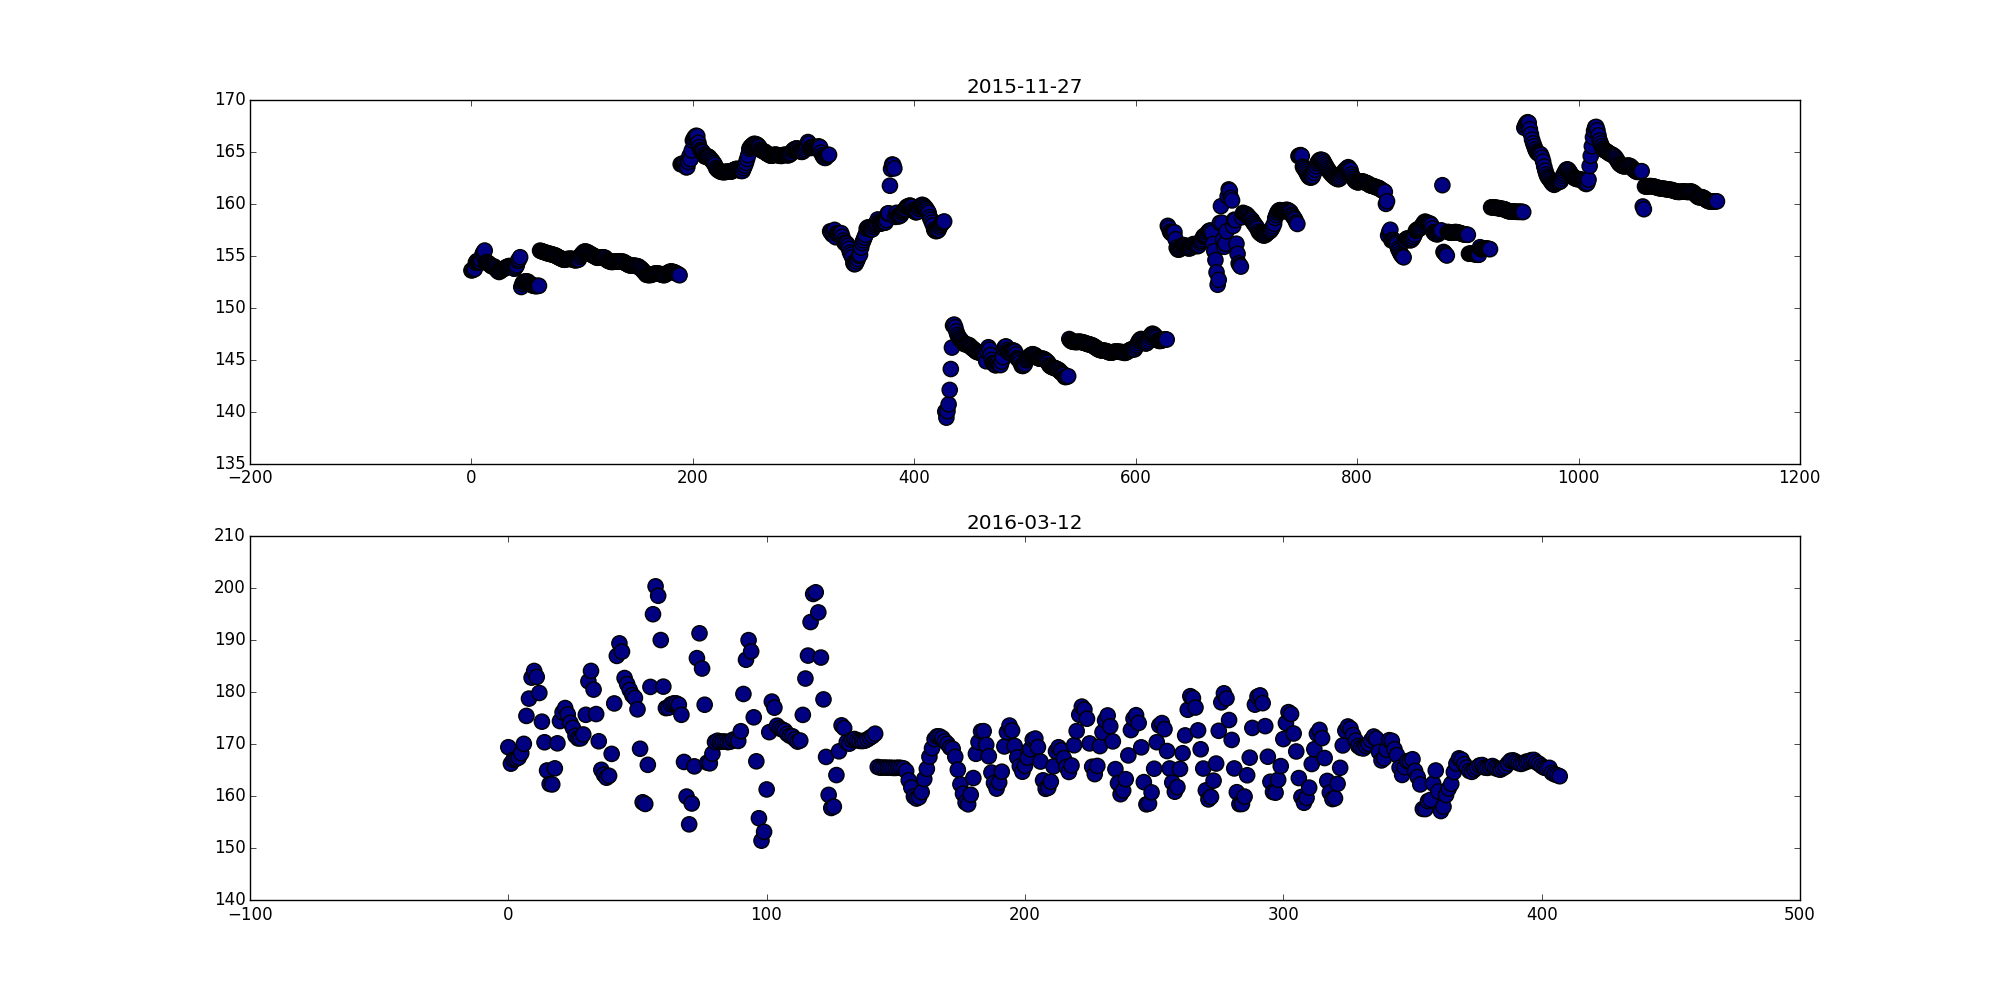

In [5]:
Image(filename='data/merged/look_straight-plots.png')


In [6]:
config = json.loads(open('config.json','r').read())
active_features = config['active_features']

0.975125032903


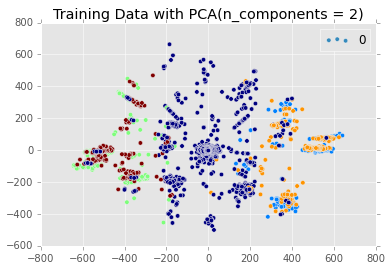

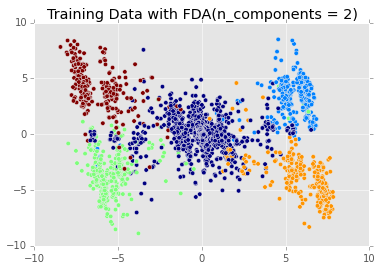

In [7]:

pca = PCA(n_components=2)
X = pca.fit_transform(df[config['active_features']])
plt.scatter(X[:,0],X[:,1], c=df['class'])
plt.title('Training Data with PCA(n_components = 2)')

plt.legend(['0','1','2','3','4'])
from sklearn.lda import LDA
lda = LDA(n_components=2)
X = lda.fit_transform(df[config['active_features']], df['class'])
plt.figure()

plt.scatter(X[:,0],X[:,1], c=df['class'])
plt.title("Training Data with FDA(n_components = 2)")

y_pred = lda.predict(df[active_features])
print sum(y_pred == df['class']) / float(len(df))

In [8]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder


def compute_metrics(X_test, Y_test, Y_pred, label):
    i = label
    id_rated_t = X_test.index[Y_pred == i]
    id_is_t = X_test.index[Y_test == i]
    n = len(X_test)
    truths = set(id_is_t)
    positives = set(id_rated_t)
    tp = len(truths.intersection(positives))
    fp = len(positives.difference(truths.intersection(positives)))
    fn = len(truths.difference(truths.intersection(positives)))
    tn = n - tp - fp - fn


    precision = tp / float(max([1,fp + tp]))
    recall = tp / float(max([1,tp + fn]))
    accuracy = (tp + tn) / float(n)
    return (precision, recall, accuracy)

def train_split_classify(df, active_features, y_feature, clf, k = 4, verbose=False,
                        class_label_append = ''):
    X = df[active_features]
    Y = LabelEncoder().fit_transform(df[y_feature])
    classes = set(Y)
    accuracies = [[]]*len(classes)
    recalls = [[]]*len(classes)
    precisions = [[]]*len(classes)
    print '\n======\n'
    print 'Cross validating for', clf.__class__

    for i in xrange(k):
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.3, random_state=42
        )
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)

        for i in classes:

            precision, recall, accuracy = compute_metrics(X_test, Y_test, Y_pred, i)
            accuracies[i].append(accuracy)
            recalls[i].append(recall)
            precisions[i].append(precision)
            if verbose==True:
                print "Class", i 
                print 'precision', precision
                print 'recall', recall
                print 'accuracy', accuracy
                print '\n======'
    
    metrics = []
    for i in classes:
        metrics.append(dict(
            label=i,
            precision=np.mean(precisions[i]),
            recall=np.mean(recalls[i]),
            accuracy=np.mean(accuracies[i]),
            classifier=str(clf.__class__) + class_label_append,
            ))
    return metrics
#     print 'Confusion Matrix:', sum(cof_mat)
#     print 'Accuracy:', np.mean(accuracies)
#     print 'Recall:', np.mean(recalls)
#     print 'Precision:', np.mean(precisions)

In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


res = []
# svm = SVC()
# res += train_split_classify(df, config['active_features'], 'class',svm)

rf = RandomForestClassifier()
res += train_split_classify(df, config['active_features'], 'class',rf)

gbc = GradientBoostingClassifier()
res += train_split_classify(df, config['active_features'], 'class',gbc)

knn = KNeighborsClassifier(n_neighbors=10)
res += train_split_classify(df, config['active_features'], 'class',knn,  class_label_append='k=10')


knn2 = KNeighborsClassifier(n_neighbors=5)
res += train_split_classify(df, config['active_features'], 'class',knn2, class_label_append='k=5')


# combine results
df_res = pd.DataFrame(res)



Cross validating for <class 'sklearn.ensemble.forest.RandomForestClassifier'>


Cross validating for <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>


Cross validating for <class 'sklearn.neighbors.classification.KNeighborsClassifier'>


Cross validating for <class 'sklearn.neighbors.classification.KNeighborsClassifier'>


In [10]:
df_res.groupby('classifier').mean()[['accuracy', 'precision','recall']]

,accuracy,precision,recall
classifier,,,
<class 'sklearn.ensemble.forest.RandomForestClassifier'>,0.993991,0.974008,0.931108
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>,0.994167,0.967273,0.945892
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>k=10,0.992982,0.966167,0.920147
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>k=5,0.991842,0.961700,0.905156


# Testing on Pure Test Data

In [11]:
df_left_test = pd.read_csv('data/merged/look_left_test.csv')
df_right_test = pd.read_csv('data/merged/look_right_test.csv')

df_straight_test = pd.read_csv('data/merged/look_straight_test.csv')
### hack
# Assume class 0 is always when face is forward for any data set

# look-right events are class 3 and 4
df_right_test['class'] = df_right_test['class'].apply(lambda x: x + 2 if x > 0 else 0)
df_test = pd.concat([df_left_test, df_right_test, df_straight_test])


In [12]:
def compute_test_data(df, df_test, clf):
    Y_test = df_test['class']
    classes = set(Y_test)
    X_test = df_test[active_features]
    clf.fit(df[active_features], df['class'])
    Y_pred = clf.predict(X_test)
    print 'PREDICTING TEST RESULTS FOR ', clf.__class__
    for i in classes:
        print i
        print compute_metrics(X_test, Y_test, Y_pred,i)

In [13]:
compute_test_data(df, df_test, rf)
compute_test_data(df, df_test, knn)

PREDICTING TEST RESULTS FOR  <class 'sklearn.ensemble.forest.RandomForestClassifier'>
0
(0.8783382789317508, 0.976897689768977, 0.9285714285714286)
1
(0.9916666666666667, 0.7828947368421053, 0.9747023809523809)
2
(0.8673469387755102, 0.5862068965517241, 0.9456845238095238)
3
(0.8169014084507042, 0.9830508474576272, 0.9895833333333334)
4
(0.9, 0.9642857142857143, 0.9940476190476191)
PREDICTING TEST RESULTS FOR  <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
0
(0.9067278287461774, 0.9785478547854786, 0.9449404761904762)
1
(0.9919354838709677, 0.8092105263157895, 0.9776785714285714)
2
(0.8545454545454545, 0.6482758620689655, 0.9501488095238095)
3
(0.859375, 0.9322033898305084, 0.9903273809523809)
4
(0.765625, 0.875, 0.9836309523809523)


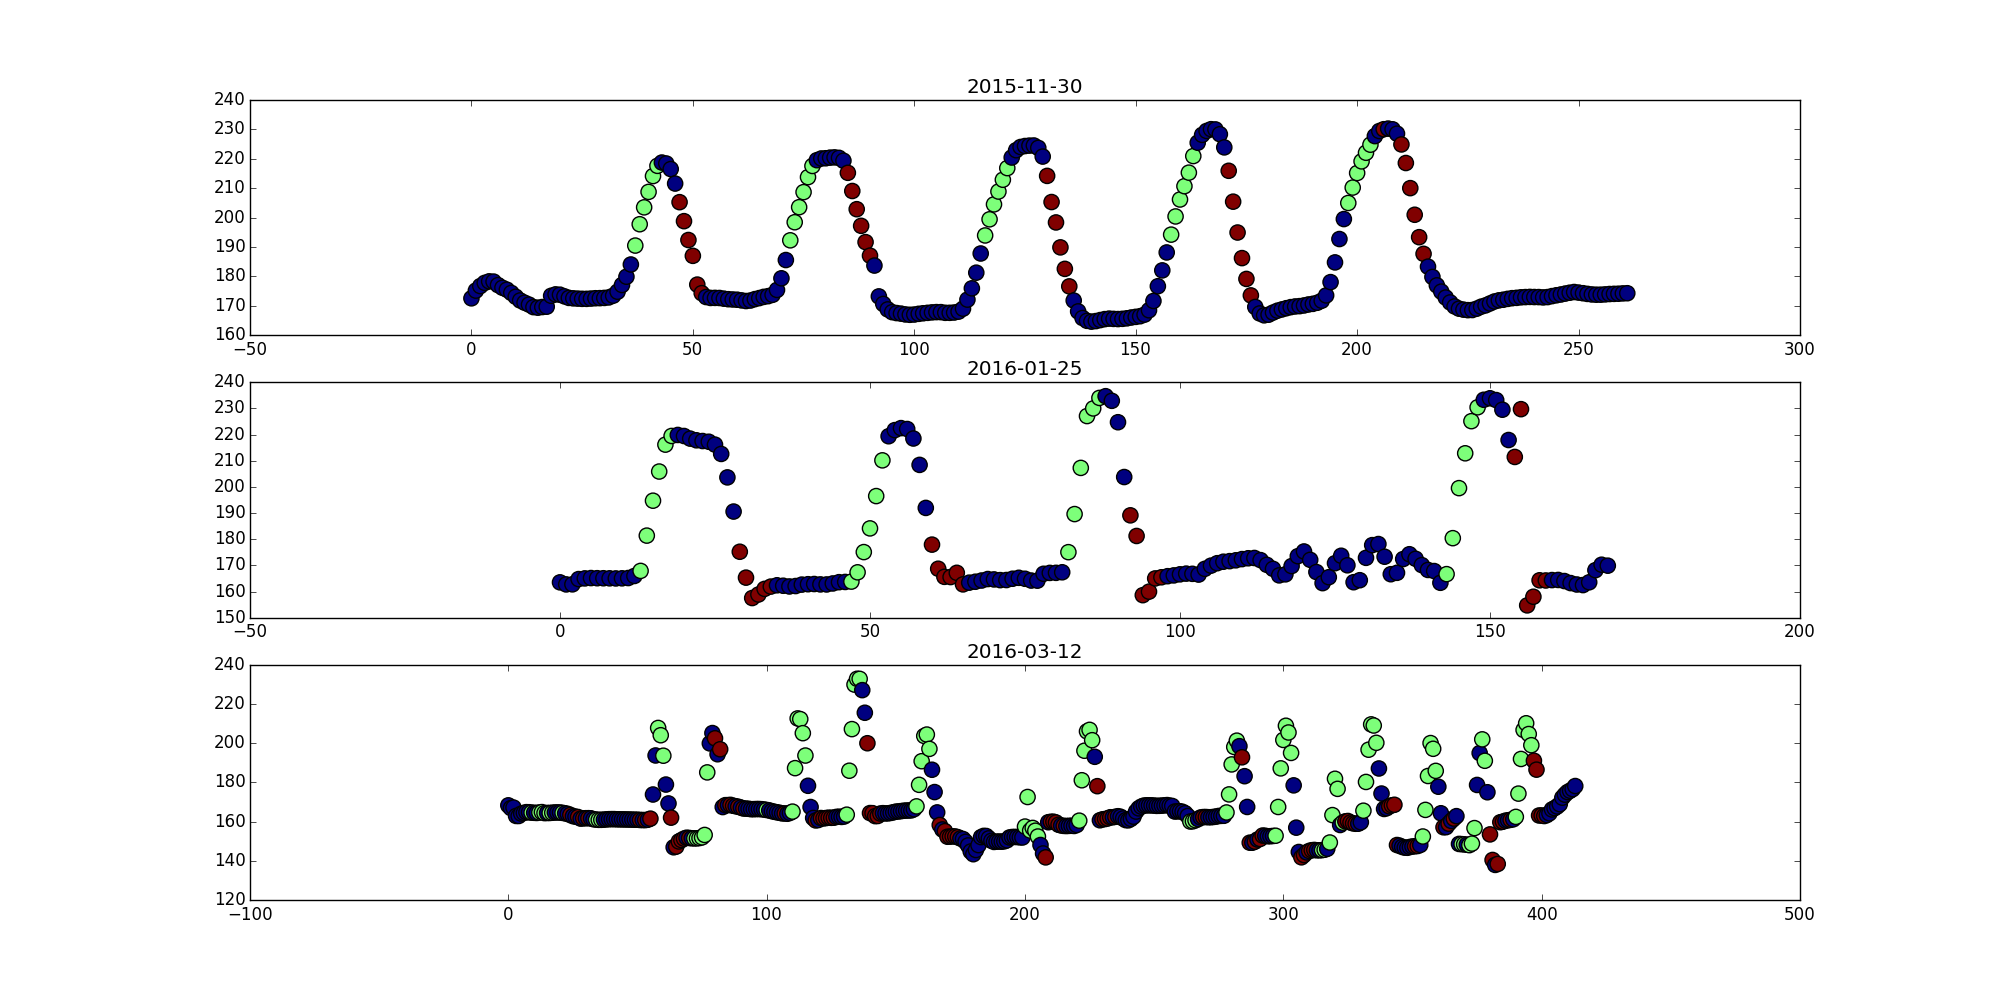

In [14]:
Image(filename='data/merged/look_left_test-plots.png')


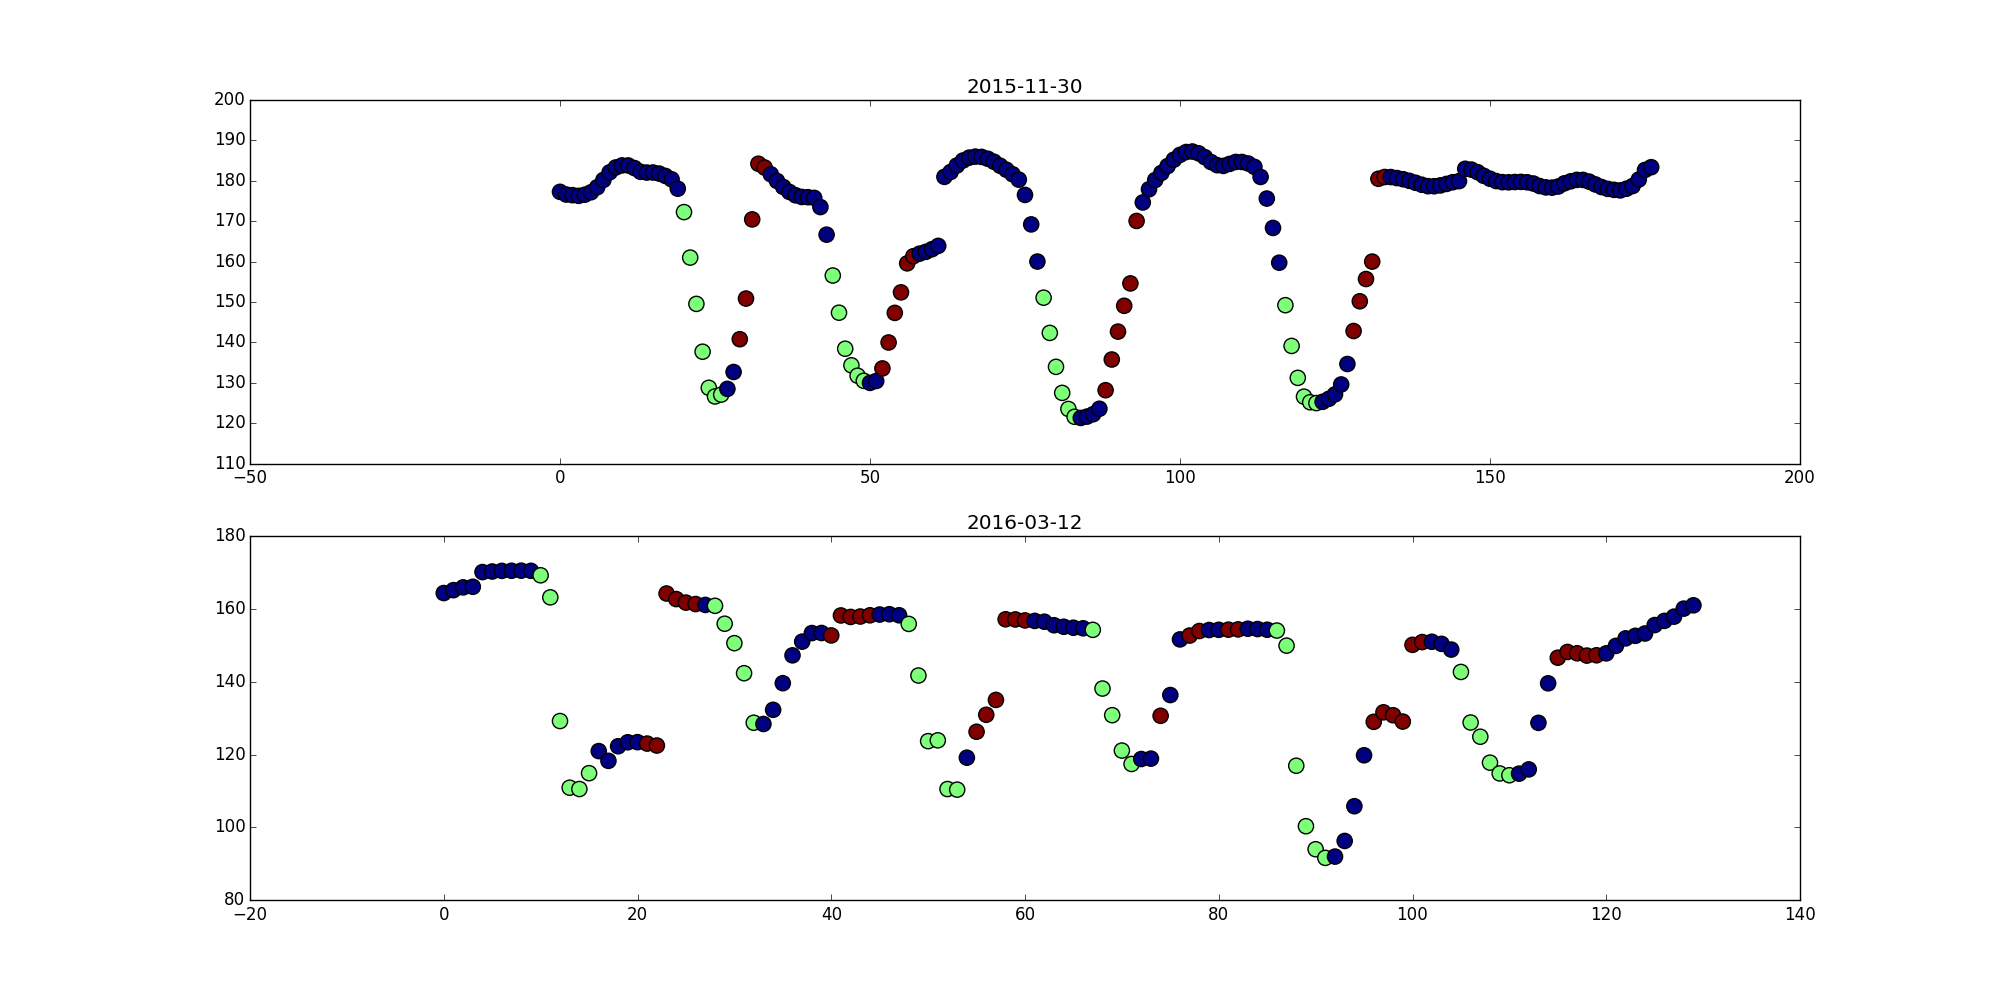

In [15]:
Image(filename='data/merged/look_right_test-plots.png')


# PART 2: Feature Engineering

In [16]:
import cluster_merge
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from head_features import DeltaFeatureGenerator
def apply_m_feature_engineering(df, relevant_features = []):
    #return df
    df_b = df.copy()
    sub_frames = []
    # these are all "historic" systems
    ignore_columns = [c for c in df_b.columns.tolist() if c not in relevant_features]
    sub_frames.append(DeltaFeatureGenerator().generate_features(
            df, suffix='_6_steps', step=6,relevant_features=relevant_features, # eignore_columns,
            ))

    sub_frames.append(DeltaFeatureGenerator().generate_features(
            df, suffix='_1_steps', step=1, relevant_features=relevant_features,
            #ignore_columns=ignore_columns,
            ))
    df_new = pd.concat(sub_frames, axis=1)
    df_new['pos_delta_x'] = df_new['noseX_1_steps'] > 0 
    active_features = df_new.columns.values.tolist()
    for c in df.columns.values.tolist():
        if not c in df_new.columns.values.tolist():
            df_new[c] = df[c]
    return df_new, active_features



In [60]:
window_size = 3
df_left, new_active_features = cluster_merge.generate_training_set(
    'data/look_left', 
    k = 3,
    verbose=False,
    window_size=window_size,
    feature_generator = apply_m_feature_engineering,
    relevant_features=config['relevant_features']
    )

df_right, new_active_features = cluster_merge.generate_training_set(
    'data/look_right', 
    k = 3,
    verbose=False,
    window_size=window_size,
    feature_generator = apply_m_feature_engineering,
    relevant_features=config['relevant_features']
    )

df_straight, new_active_features = cluster_merge.generate_training_set(
    'data/look_straight', 
    k = 1,
    verbose=False,
    window_size=window_size,
    feature_generator = apply_m_feature_engineering,
    relevant_features=config['relevant_features']
    )
df_right['class'] = df_right['class'].apply(lambda x: x + 2 if x > 0 else 0)
df_trains = pd.concat([df_left, df_right, df_straight]) 

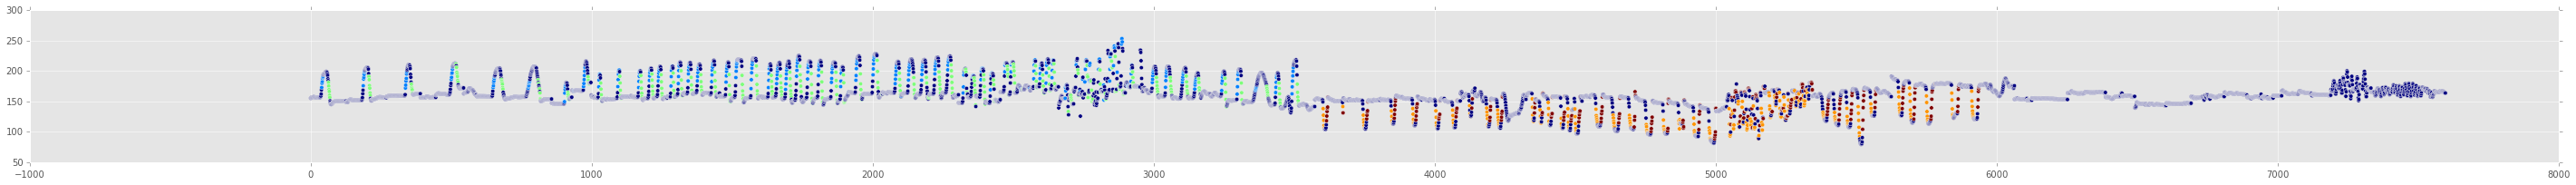

In [61]:
plt.figure(figsize=(50,3))
plt.scatter(xrange(len(df_trains)), df_trains['noseX'], c=df_trains['class'])


0.975651487233


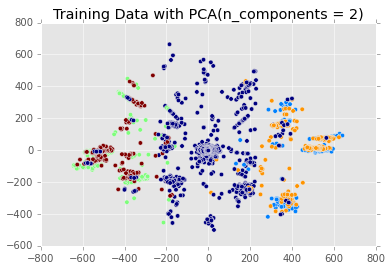

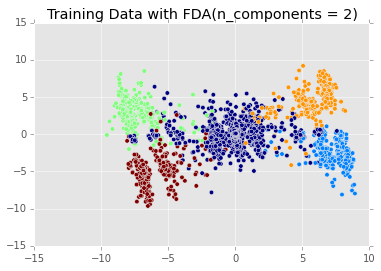

In [63]:

pca = PCA(n_components=2)
X = pca.fit_transform(df_trains[new_active_features])
plt.scatter(X[:,0],X[:,1], c=df_trains['class'])
plt.title('Training Data with PCA(n_components = 2)')

plt.legend()
from sklearn.lda import LDA
lda = LDA(n_components=2)
X = lda.fit_transform(df_trains[new_active_features], df_trains['class'])
plt.figure()

plt.scatter(X[:,0],X[:,1], c=df_trains['class'])
plt.title("Training Data with FDA(n_components = 2)")

y_pred = lda.predict(df_trains[new_active_features])
print sum(y_pred == df_trains['class']) / float(len(df))

In [67]:
df_trains[['pos_delta_x_1', 'pos_delta_x_0']]

,pos_delta_x_1,pos_delta_x_0
0,True,False
1,True,True
2,True,True
3,True,True
4,True,True
5,True,True
6,True,True
7,True,True
8,True,True
9,True,True
